In [1]:
import numpy as np

In [6]:
class RNN:
    def __init__(self,Wx,Wh,b):
        self.params=[Wx,Wh,b]
        self.grads = [np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.cache = None
        
    def forward(self,x,h_prev):
        Wx,Wh,b = self.params
        t = np.matmul(h_prev,Wh)+np.matmul(x,Wx)+b
        h_next = np.tanh(t)
        
        self.cache = (x,h_prev,h_next)
        return h_next
    
    def backward(self,dh_next):
        Wx,Wh,b = self.params
        x,h_prev,h_next = self.cache

        dt = dh_next * (1-h_next**2)
        db = np.sum(dt,axis=0)
        dWh = np.matmul(h_prev.T,dt)
        dh_prev = np.matmul(dt,Wh.T)
        dWx = np.matmul(x.T,dt)
        dx = np.matmul(dt,Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx,dh_prev

In [8]:
class TimeRNN:
    def __init__(self,Wx,Wh,b,stateful=False):
        self.params = [Wx,Wh,b]
        self.grads = [np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None,None
        self.stateful = stateful
        
    def set_state(self,h):
        self.h = h
    
    def reset_state(self):
        self.h = None
        
    def forward(self,xs):
        Wx,Wh,b = self.params
        N,T,D = xs,shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N,T,H),dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H),dtype='f')
        
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:,t,:],self.h)
            hs[:,t,:] = self.h
            self.layers.append(layer)
        return hs
    
    def backward(self,dhs):
        Wx,Wh,b = self.params
        N,T,H = dhs.shape
        D,H = Wx.shape
        
        dxs = np.empty((N,T,D),dtype='f')
        dh = 0
        grads = [0,0,0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx,dh = layer.backward(dhs[:,t,:]+dh)
            dxs[:,t,:] = dx
            
            for i ,grad in enumerate(layer.grads):
                grads[i] += grad
            
        for i,grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

Gradient

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
H = 3
T = 20

dh = np.ones((N,H))
np.random.seed(3)
Wh = np.random.randn(H,H)

norm_list =[]
for t in range(T):
    dh = np.matmul(dh,Wh.T)
    norm = np.sqrt(np.sum(dh**2))/N
    norm_list.append(norm)

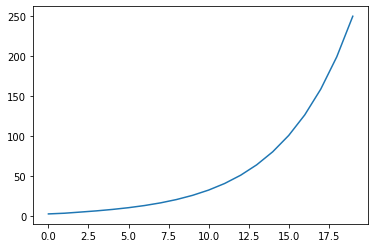

In [4]:
plt.plot(norm_list)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
H = 3
T = 20

dh = np.ones((N,H))
np.random.seed(3)
Wh = np.random.randn(H,H)*0.5

norm_list =[]
for t in range(T):
    dh = np.matmul(dh,Wh.T)
    norm = np.sqrt(np.sum(dh**2))/N
    norm_list.append(norm)

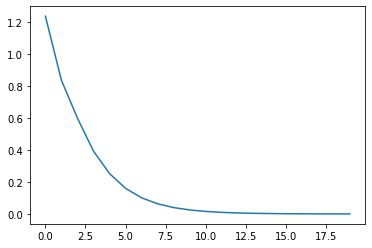

In [6]:
plt.plot(norm_list)

In [28]:
dW1 = np.random.randn(3,3)*10
dW2 = np.random.randn(3,3)*10
grads = [dW1,dW2]
max_norm = 5.0

def clip_grads(grads,max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)
    print(total_norm)
    
    rate = max_norm/(total_norm + 1e-6)
    if total_norm >= max_norm:
    
        for grad in grads:
            grad *= rate
    
    return grads

In [34]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
H = 3
T = 20

dh = np.ones((N,H))
dh2 = np.ones((N,H))
grads = [dh2]
np.random.seed(3)
Wh = np.random.randn(H,H)
clip_norm_list = []
norm_list =[]
for t in range(T):
    dh = np.matmul(dh,Wh.T)
    norm = np.sqrt(np.sum(dh**2))/N
    norm_list.append(norm)
    dh2 = np.matmul(dh2,Wh.T)
    
    c_norm = np.sqrt(np.sum(dh2**2))/N
    clip_grads(grads,5.0)
    clip_norm_list.append(c_norm)

2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178
2.449489742783178


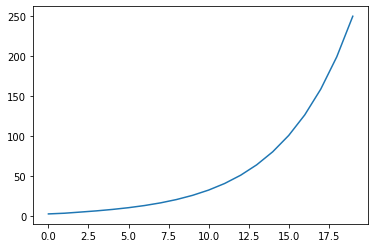

In [35]:
plt.plot(clip_norm_list)

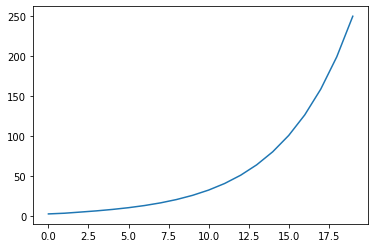

In [36]:
plt.plot(norm_list)

In [38]:
class LSTM:
    def __init__(self,Wx,Wh,b):
        self.params = [Wx,Wh,b]
        self.grads = [np.zeros_like(Wx),np.zeros_like(Wh).np.zeros_like(b)]
        self.cache = None
    
    def forward(self,x,h_prev,c_prev):
        Wx,Wh,b = self.params
        N,H = h_prev.shape
        
        A = np.matmul(x,Wx) + np.matmul(h_prev,Wh)+b
        
        f = A[:,:H]
        g = A[:,H:2*H]
        i = A[:,2*H:3*H]
        o = A[:,3*H:]
        
        f = 1/(1+np.exp(-f))
        g = np.tanh(g)
        i = 1/(1+np.exp(-i))
        o = 1/(1+np.exp(-o))
        
        c_next = f*c_prev + g*i
        h_next = o*np.tanh(c_next)
        
        self.cache = (x,h_prev,c_prev,i,f,g,o,c_next)
        return h_next,c_next

In [40]:
class TimeLSTM:
    def __init__(self,Wx,Wh,b,stateful =True):
        self.params = [Wx,Wh,b]
        self.grads = [np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.layers = None
        self.h , self.c = None,None
        self.dh = None
        self.stateful = stateful
        
    def forward(self,xs):
        Wx,Wh,b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N,T,H),dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H),dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N,H),dtype='f')
            
        for t in range(T):
            layer = LSTM(*self.parmas)
            self.h , self.c = layer.forward(xs[:,t,:],self.h,self.c)
            hs[:,t,:] = self.h
            
            self.layers.append(layer)
        return hs
    
    def backwrad(self,dhs):
        Wx,Wh,b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N,T,D),dtype='f')
        dh,dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx,dh,dc = layer.backward(dhs[:,t,:]+dh,dc)
            dxs[:,t,:] =dx
            for i, grad in enumerate(layers.grads):
                grads[i] += grad
            
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh
            return dxs
    
    def set_state(self,h,c=None):
        self.h,self.c = h,c
    
    def reset_state(self):
        self.h,self.c = None,None